<a href="https://colab.research.google.com/github/jeonggyunH/jeonggyunH/blob/main/Colaboratory%EC%97%90_%EC%98%A4%EC%8B%A0_%EA%B2%83%EC%9D%84_%ED%99%98%EC%98%81%ED%95%A9%EB%8B%88%EB%8B%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import os
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

from numpy.random import randn
from matplotlib import pyplot
data = pd.read_csv('/content/allcombGan.csv')
# data = pd.read_csv('/Iris.csv')
print (data.shape)
print (data.tail())
print (data.columns)


(3028, 5)
       press     rr          zz            ne  output
3023  1.3332  225.0   96.392431  7.990000e+13       0
3024  1.3332  225.0  101.814736  6.090000e+13       1
3025  1.3332  225.0  101.814736  9.660000e+13       0
3026  1.3332  225.0  108.000000  5.630000e+13       1
3027  1.3332  225.0  108.000000 -4.180000e+12       0
Index(['press', 'rr', 'zz', 'ne', 'output'], dtype='object')


In [2]:
data.columns

Index(['press', 'rr', 'zz', 'ne', 'output'], dtype='object')

In [3]:
data.isnull().sum()


press     0
rr        0
zz        0
ne        0
output    0
dtype: int64

In [4]:
data.shape


(3028, 5)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3028 entries, 0 to 3027
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   press   3028 non-null   float64
 1   rr      3028 non-null   float64
 2   zz      3028 non-null   float64
 3   ne      3028 non-null   float64
 4   output  3028 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 118.4 KB


In [7]:
features = ['press', 'rr', 'zz', 'ne']

label = ['output']
X = data[features]
y = data[label]
print (y)

      output
0          1
1          0
2          1
3          0
4          1
...      ...
3023       0
3024       1
3025       0
3026       1
3027       0

[3028 rows x 1 columns]


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X_true_train, X_true_test, y_true_train, y_true_test = train_test_split(X, y, test_size=0.30, random_state=42)
clf_true = RandomForestClassifier(n_estimators=100)
clf_true.fit(X_true_train,y_true_train)

y_true_pred=clf_true.predict(X_true_test)
print("Base Accuracy:",metrics.accuracy_score(y_true_test, y_true_pred))
print("Base classification report:",metrics.classification_report(y_true_test, y_true_pred))
     

<ipython-input-8-dcc6f606a0c9>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_true.fit(X_true_train,y_true_train)


Base Accuracy: 0.429042904290429
Base classification report:               precision    recall  f1-score   support

           0       0.44      0.41      0.43       470
           1       0.42      0.45      0.43       439

    accuracy                           0.43       909
   macro avg       0.43      0.43      0.43       909
weighted avg       0.43      0.43      0.43       909



In [9]:
X.shape

(3028, 4)

In [10]:
data.shape

(3028, 5)

In [11]:
print (y_true_test)

      output
1207       0
256        1
2355       0
175        0
211        0
...      ...
2513       0
1866       1
2115       0
2607       0
2897       0

[909 rows x 1 columns]


In [12]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

  # use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = np.zeros((n_samples, 1))
	return X, y

  # generate n real samples with class labels
def generate_real_samples(n):
  X = data.sample(n)

  #generate class labels
  y = np.ones((n, 1))
  return X, y

  # define the standalone generator model
def define_generator(latent_dim, n_outputs=5):
  model = Sequential()
  model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
  model.add(Dense(30, activation='relu'))
  # model.add(Dense(n_outputs, activation='sigmoid'))
  model.add(Dense(n_outputs, activation='linear'))
  return model

In [13]:
generator1 = define_generator(10, 5)
generator1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                165       
                                                                 
 dense_1 (Dense)             (None, 30)                480       
                                                                 
 dense_2 (Dense)             (None, 5)                 155       
                                                                 
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________


In [14]:
# from keras.layers import Reshape
# from keras.layers import Flatten
# from keras.layers import Conv2D
# from keras.layers import Conv2DTranspose
# from keras.layers import LeakyReLU
# from keras.layers import BatchNormalization
# from keras.initializers import RandomNormal
# from matplotlib import pyplot

In [15]:
# define the standalone discriminator model
def define_discriminator(n_inputs=5):
  model = Sequential()
  # model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer='he_uniform', input_shape=n_inputs))
  # model.add(BatchNormalization())
  # model.add(LeakyReLU(alpha=0.2))
  # model.add(Dense(25, activation='relu'))
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
	# compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [16]:
discriminator1 = define_discriminator(5)
discriminator1.summary()
     

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                150       
                                                                 
 dense_4 (Dense)             (None, 50)                1300      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________


In [17]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [18]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
	# plot loss
	plt.subplot(1, 1, 1)
	plt.plot(d_hist, label='d')
	plt.plot(g_hist, label='gen')
	# plt.legend()
	# plot discriminator accuracy
	# pyplot.subplot(2, 1, 2)
	# pyplot.plot(a1_hist, label='acc-real')
	# pyplot.plot(a2_hist, label='acc-fake')
	plt.show()
	# save plot to file
	# plt.savefig('results_baseline/plot_line_plot_loss.png')
	plt.close()

In [19]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128):
  
  # determine half the size of one batch, for updating the discriminator
  half_batch = int(n_batch / 2)

  d_history = []
  g_history = []
  
  # manually enumerate epochs
  for epoch in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator
    d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
    d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    
    # create inverted labels for the fake samples
    y_gan = np.ones((n_batch, 1))
    
    # update the generator via the discriminator's error
    g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)

    print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
    d_history.append(d_loss)
    g_history.append(g_loss_fake)

  plot_history(d_history, g_history)

    # if i==999:
    #   np.savetxt("new_X.csv", X, delimiter=",")
    
    # evaluate the model every n_eval epochs
    # if (i+1) % n_eval == 0:
    #   summarize_performance(i, g_model, d_model, latent_dim)
  g_model.save('trained_generated_model_20210205_v3.h5')

In [20]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
  # scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], color='red')
	pyplot.scatter(x_fake[:, 0], color='blue')
	pyplot.show()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
2/2 [==============================] - 0s 4ms/step
>7501, d1=0.000, d2=43.747 d=21.873 g=0.000
2/2 [==============================] - 0s 5ms/step
>7502, d1=0.000, d2=45.381 d=22.690 g=0.000
2/2 [==============================] - 0s 12ms/step
>7503, d1=0.000, d2=39.740 d=19.870 g=0.000
2/2 [==============================] - 0s 4ms/step
>7504, d1=0.000, d2=40.471 d=20.235 g=0.000
2/2 [==============================] - 0s 6ms/step
>7505, d1=0.000, d2=49.532 d=24.766 g=0.000
2/2 [==============================] - 0s 5ms/step
>7506, d1=0.000, d2=43.069 d=21.534 g=0.000
2/2 [==============================] - 0s 4ms/step
>7507, d1=0.000, d2=46.661 d=23.331 g=0.000
2/2 [==============================] - 0s 3ms/step
>7508, d1=0.000, d2=40.976 d=20.488 g=0.000
2/2 [==============================] - 0s 3ms/step
>7509, d1=0.000, d2=45.007 d=22.504 g=0.000
2/2 [==============================] - 0s 4ms/step
>7510, d1=0.000, d2=45.699 d=22.850 g=0.000
2/2 [========

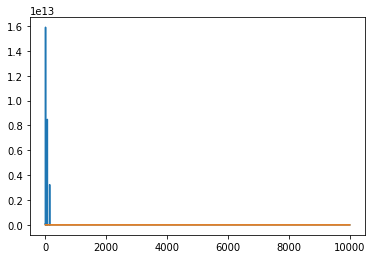

In [21]:
# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

In [22]:
from keras.models import load_model
model = load_model('/content/trained_generated_model_20210205_v3.h5')

In [31]:
latent_points = generate_latent_points(10, 3028)
X = model.predict(latent_points)
data_fake = pd.DataFrame(data=X,  columns=['press', 'rr', 'zz', 'ne', 'output'])
data_fake.head(3028)

95/95 [==============================] - 0s 1ms/step


,press,rr,zz,ne,output
0,2.601167,-1.848138,-0.284178,592.132568,-3.230792
1,3.318683,-0.613377,1.683814,562.642517,-2.680235
2,2.233155,-1.499567,-1.096375,518.196350,-1.897833
3,2.692303,-1.418808,0.921651,551.658264,-2.494844
4,2.314813,-1.771968,-0.723188,520.987366,-1.540346
...,...,...,...,...,...
3023,2.730974,-1.032389,1.062761,489.156097,-1.877759
3024,2.391501,0.103812,0.503516,449.117462,-2.328261
3025,2.194653,-0.920780,-0.470000,590.840393,-2.605222
3026,3.274032,-1.267192,0.382864,535.299927,-3.634915


In [32]:
data_fake.output.min()

-6.4009085

In [33]:
data_fake.output.max()

-0.7068993

In [34]:
outcome_mean = data_fake.output.mean()

In [35]:
data_fake['output'] = data_fake['output'] > outcome_mean

In [36]:
data_fake['output']

0       False
1        True
2        True
3        True
4        True
        ...  
3023     True
3024     True
3025     True
3026    False
3027     True
Name: output, Length: 3028, dtype: bool

In [37]:
data_fake["output"] = data_fake["output"].astype(int)

In [38]:
data_fake.head(3028)

,press,rr,zz,ne,output
0,2.601167,-1.848138,-0.284178,592.132568,0
1,3.318683,-0.613377,1.683814,562.642517,1
2,2.233155,-1.499567,-1.096375,518.196350,1
3,2.692303,-1.418808,0.921651,551.658264,1
4,2.314813,-1.771968,-0.723188,520.987366,1
...,...,...,...,...,...
3023,2.730974,-1.032389,1.062761,489.156097,1
3024,2.391501,0.103812,0.503516,449.117462,1
3025,2.194653,-0.920780,-0.470000,590.840393,1
3026,3.274032,-1.267192,0.382864,535.299927,0


In [40]:
features = ['press', 'rr', 'zz', 'ne', 'output']

label = ['output']
X_fake_created = data_fake[features]
y_fake_created = data_fake[label]

In [41]:
X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(X_fake_created, y_fake_created, test_size=0.30, random_state=42)
clf_fake = RandomForestClassifier(n_estimators=100)
clf_fake.fit(X_fake_train,y_fake_train)

y_fake_pred=clf_fake.predict(X_fake_test)
print("Accuracy of fake data model:",metrics.accuracy_score(y_fake_test, y_fake_pred))
print("Classification report of fake data model:",metrics.classification_report(y_fake_test, y_fake_pred))
     

<ipython-input-41-d6030bbaf5bb>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_fake.fit(X_fake_train,y_fake_train)


Accuracy of fake data model: 1.0
Classification report of fake data model:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       419
           1       1.00      1.00      1.00       490

    accuracy                           1.00       909
   macro avg       1.00      1.00      1.00       909
weighted avg       1.00      1.00      1.00       909



In [42]:
X_final = X[:, :4]
print ('X_final: ', X_final[:3])

y_final = X[:, :]
print ('y_final: ', y_final[:3])

X_final:  [[ 2.6011674e+00 -1.8481380e+00 -2.8417820e-01  5.9213257e+02]
 [ 3.3186831e+00 -6.1337680e-01  1.6838138e+00  5.6264252e+02]
 [ 2.2331555e+00 -1.4995666e+00 -1.0963749e+00  5.1819635e+02]]
y_final:  [[ 2.6011674e+00 -1.8481380e+00 -2.8417820e-01  5.9213257e+02
  -3.2307920e+00]
 [ 3.3186831e+00 -6.1337680e-01  1.6838138e+00  5.6264252e+02
  -2.6802354e+00]
 [ 2.2331555e+00 -1.4995666e+00 -1.0963749e+00  5.1819635e+02
  -1.8978328e+00]]


In [43]:
X = X [:,:4]
y_fake_pred = clf_true.predict(X)
y_fake_pred

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 0])

In [44]:
!pip install table_evaluator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 285 kB 9.8 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [45]:
data_fake.shape

(3028, 5)

In [46]:
data.shape

(3028, 5)

In [48]:
data_fake.head(3028)

,press,rr,zz,ne,output
0,2.601167,-1.848138,-0.284178,592.132568,0
1,3.318683,-0.613377,1.683814,562.642517,1
2,2.233155,-1.499567,-1.096375,518.196350,1
3,2.692303,-1.418808,0.921651,551.658264,1
4,2.314813,-1.771968,-0.723188,520.987366,1
...,...,...,...,...,...
3023,2.730974,-1.032389,1.062761,489.156097,1
3024,2.391501,0.103812,0.503516,449.117462,1
3025,2.194653,-0.920780,-0.470000,590.840393,1
3026,3.274032,-1.267192,0.382864,535.299927,0


In [49]:
data.head(3028)

,press,rr,zz,ne,output
0,1.3332,0.0,0.000000,7.050000e+13,1
1,1.3332,0.0,0.000000,2.700000e+13,0
2,1.3332,0.0,0.258390,1.080000e+14,1
3,1.3332,0.0,0.258390,8.630000e+13,0
4,1.3332,0.0,0.620137,1.800000e+14,1
...,...,...,...,...,...
3023,1.3332,225.0,96.392431,7.990000e+13,0
3024,1.3332,225.0,101.814736,6.090000e+13,1
3025,1.3332,225.0,101.814736,9.660000e+13,0
3026,1.3332,225.0,108.000000,5.630000e+13,1


In [51]:
from table_evaluator import load_data, TableEvaluator

In [52]:
table_evaluator = TableEvaluator(data, data_fake)

In [53]:
table_evaluator.evaluate(target_col='output')

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())



Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.4769   0.7525              0.2880
DecisionTreeClassifier_real   0.5132   0.4719              0.3131
LogisticRegression_fake       0.4769   0.8135              0.2976
LogisticRegression_real       0.4719   0.5281              0.0000
MLPClassifier_fake            0.5231   0.5297              0.9869
MLPClassifier_real            0.5281   0.4719              0.8938
RandomForestClassifier_fake   0.4769   0.7987              0.2907
RandomForestClassifier_real   0.4505   0.4472              0.2839

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    1.0871
nearest neighbor std                     0.3484

Miscellaneous results:
                                  Result
Column Cor

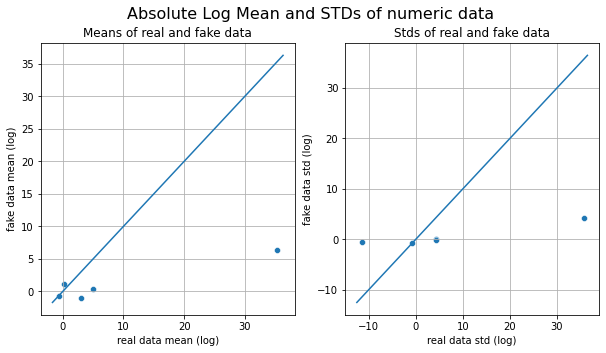

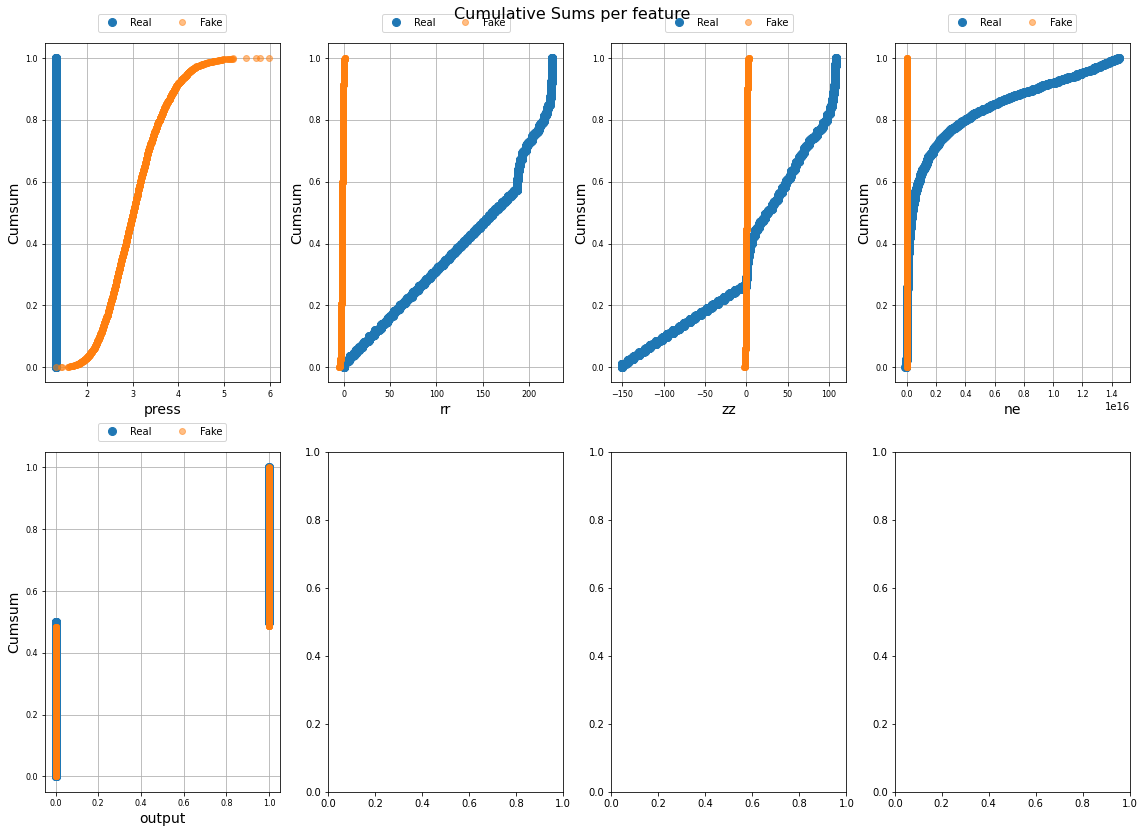

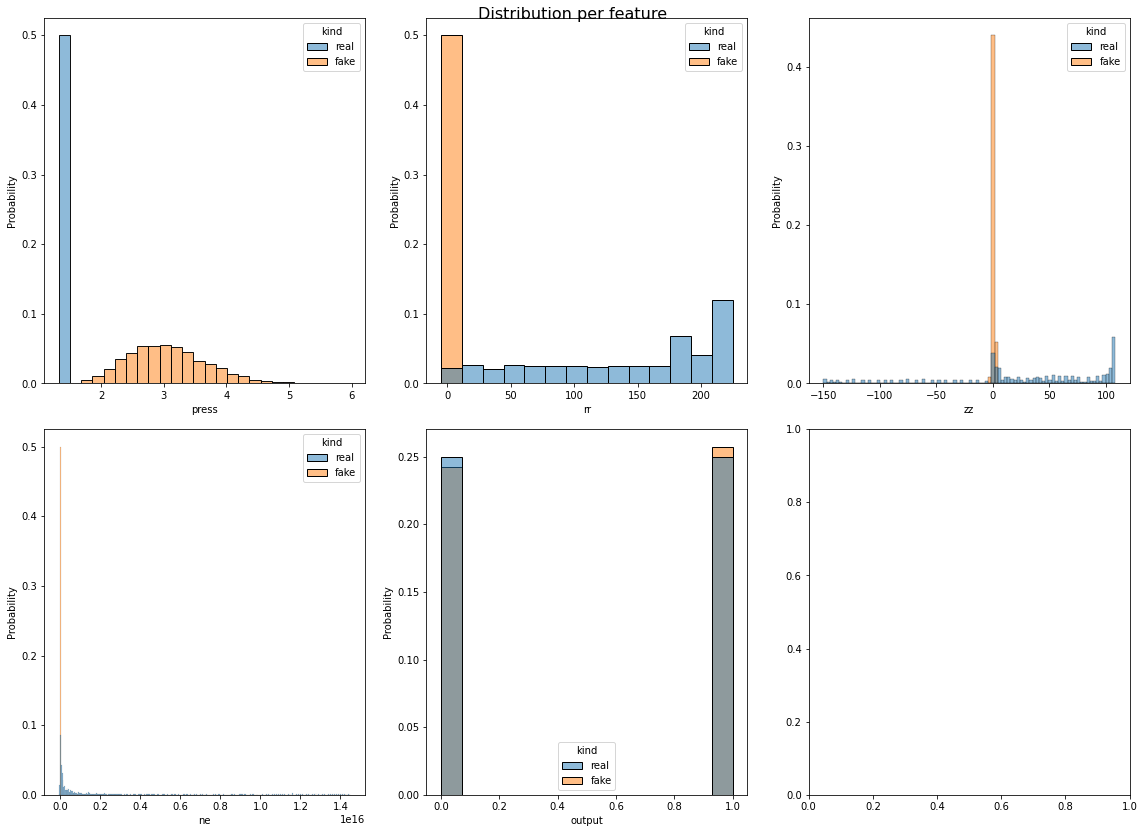

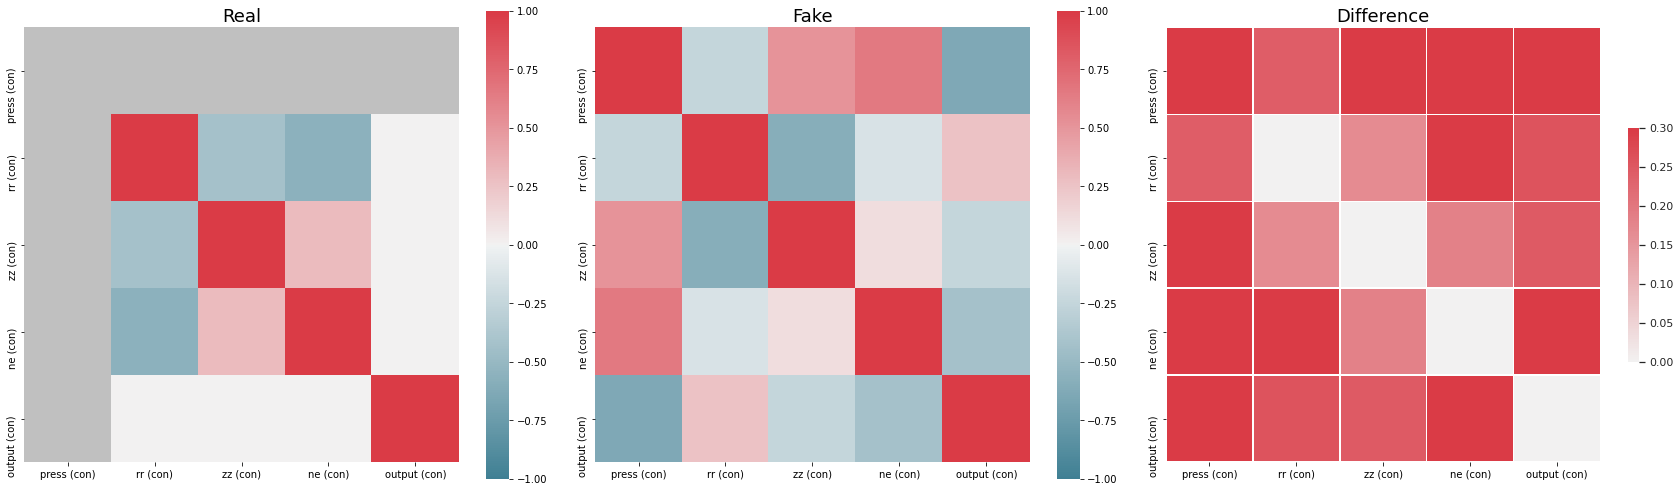

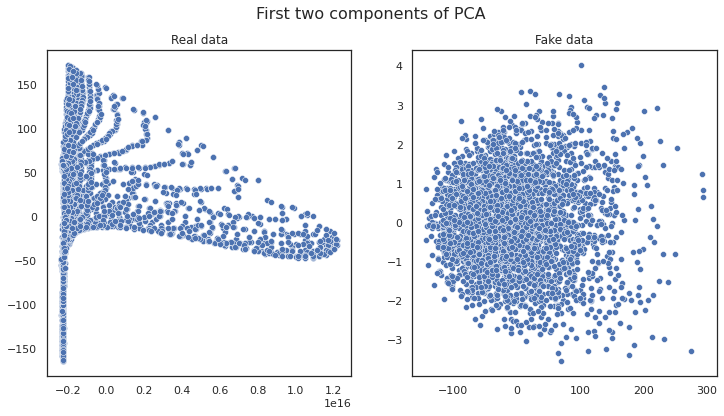

In [54]:
table_evaluator.visual_evaluation()